# Load dataset

In [1]:
import pandas as pd

In [2]:
raw_df = pd.read_csv("data/X.csv", header=None)

### Fix column headers
Use wavelengths from `Wavelength.csv` as column headers of data.

In [3]:
wavelengths = pd.read_csv("data/Wavelength.csv", header=None)
wavelength_df = raw_df.rename(columns=wavelengths.T.loc[0])

### Read output values

In [4]:
y = pd.read_csv("data/y.csv", header=None)

# Turn pandas rows into single vector
y = y[0]

# Split training and test set

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(wavelength_df, y, stratify=y,test_size=0.3, random_state=24)

# Preprocessing

### Data Visualisation

In [6]:
import matplotlib.pyplot as plt

### Visualise dataset
Just like the binary task, but more colours have to be used

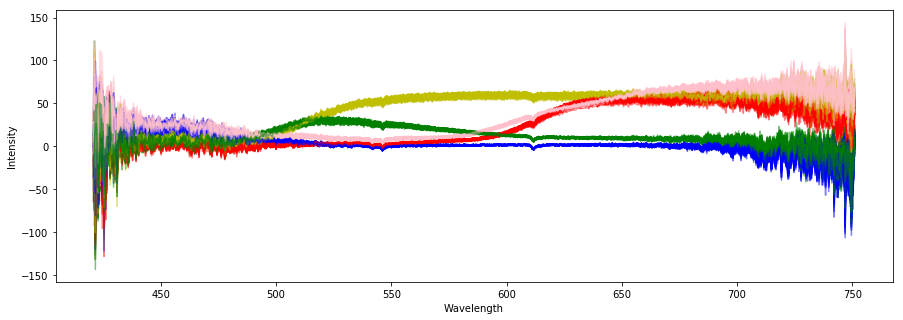

In [7]:
plt.figure(figsize=(15,5))
for i,row in X_train.iterrows():
    output = y_train[i]
    if output == 0:
        color = 'b'
    elif output == 1:
        color = 'g'
    elif output == 2:
        color = 'pink'
    elif output == 3:
        color = 'r'
    elif output == 4:
        color = 'y'
        
    ax = row.plot(color=color, alpha=0.5)
    ax.set_xlabel("Wavelength")
    ax.set_ylabel("Intensity")
plt.show()

### Plot correlation of each input feature

In [8]:
# Add output column to check correlation
correlation_data = X_train.assign(output=y_train)

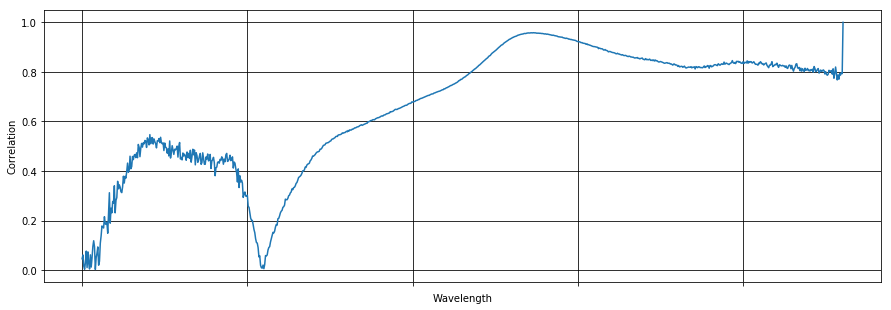

In [9]:
plt.figure(figsize=(15,5))
ax = correlation_data.corr()["output"].map(abs).plot()
ax.set_xlabel("Wavelength")
ax.set_ylabel("Correlation")
ax.grid(color='black', linestyle="-")
plt.show()

### Plot histogram of single input feature
This would be expected to be not as effective as in the binary task as there are five classes rather than just two.

In [10]:
def inputfeature_hist(feature, X, y):
    oneX = X[[X.columns[feature]]]
    oneX["output"] = y
    
    # Plot figure, filtering colours by actual output values
    ax = oneX[oneX["output"] == 0][oneX.columns[0]].plot.hist(color='b', alpha=0.5, bins=25)
    ax = oneX[oneX["output"] == 1][oneX.columns[0]].plot.hist(color='g', alpha=0.5, bins=25)
    ax = oneX[oneX["output"] == 2][oneX.columns[0]].plot.hist(color='pink', alpha=1, bins=25)
    ax = oneX[oneX["output"] == 3][oneX.columns[0]].plot.hist(color='r', alpha=0.5, bins=25)
    ax = oneX[oneX["output"] == 4][oneX.columns[0]].plot.hist(color='y', alpha=0.5, bins=25)
    ax.set_xlabel("Intensity")
    ax.set_title("Input feature wavelength " + str(X.columns[feature]))
    plt.show()

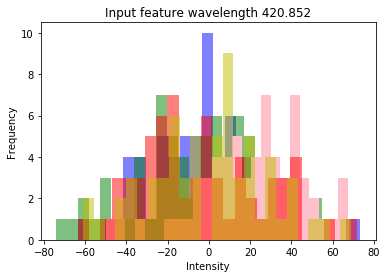

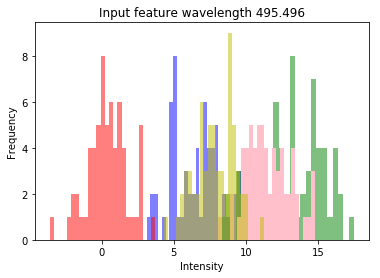

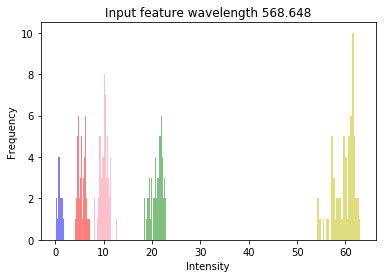

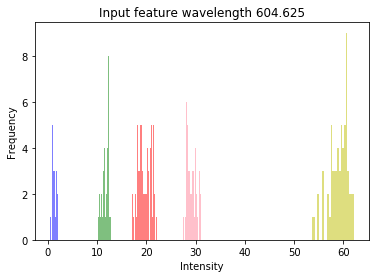

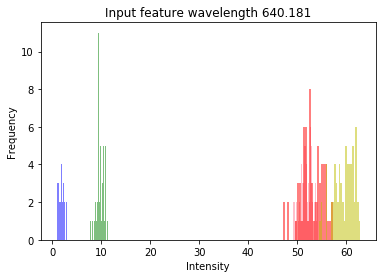

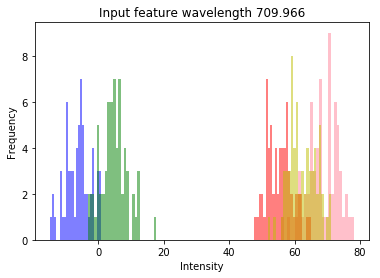

In [11]:
import warnings
warnings.filterwarnings('ignore')

for i in [0,200,400,500,600,800]:
    inputfeature_hist(i, X_train, y_train)

# Training

### Less input features
Should be able to use less input features as binary demonstrated and histograms show some input features have good distinction between colours

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV

# Recursive feature elimination with cross validation to find optimal number of features
lr_rfecv = LogisticRegression()
rfecv = RFECV(lr_rfecv, step=1, scoring="accuracy", cv=5)
rfecv.fit(X_train, y_train)

RFECV(cv=5,
   estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

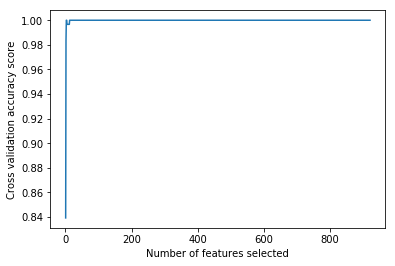

In [13]:
# Plot all features
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation accuracy score")
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.show()

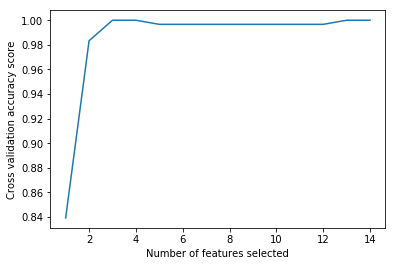

In [14]:
# Closer look at dip in accuracy
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation accuracy score")
plt.plot(range(1, 15), rfecv.grid_scores_[:14])
plt.show()

In [ ]:
from sklearn.feature_selection import RFE

indices = {}
# Recursive feature elimination to get the best 1-4 features
for i in [1,2,3,4]:
    lr_rfe = LogisticRegression()
    rfe = RFE(lr_rfe, i, step=1)
    rfe.fit(X_train, y_train)
    
    indices[i] = [j for j,x in enumerate(list(rfe.ranking_)) if x == 1]

In [ ]:
for n,features in indices.items():
    print("Best " + str(n) + " features: " + str(features))

In [ ]:
def train_and_test(indices, X, y):
    reducedX = X[X.columns[indices].tolist()]
    
    lr = LogisticRegression()
    lr.fit(reducedX, y)
    
    predictions = lr.predict(reducedX)
    print("Training accuracy: " + str(accuracy_score(y, predictions)))
    
    return lr

In [ ]:
for n,features in indices.items():
    print("Training with " + str(n) + " features:")
    train_and_test(features, X_train, y_train)
    print("")

### Cross validation
Try using k-fold cross validation to reduce overfitting

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score

for n,features in indices.items():
    reducedX = X_train[X_train.columns[features].tolist()]
    scores = cross_val_score(LogisticRegression(), reducedX, y_train, scoring="accuracy", cv=10)
    print(str(n) + " features with cross validation:")
    print(str(scores))
    print(str(np.mean(scores)) + "\n")

In [ ]:
#Try higher k-fold (k=50)
for n,features in indices.items():
    reducedX = X_train[X_train.columns[features].tolist()]
    scores = cross_val_score(LogisticRegression(), reducedX, y_train, scoring="accuracy", cv=50)
    print(str(n) + " features with cross validation:")
    print(str(scores))
    print(str(np.mean(scores)) + "\n")

### Less training samples

In [ ]:
# Further split training set to 90% testing 10% training
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_train, y_train, test_size = 0.9, random_state=34)

print("Small training set size: " + str(len(X_train_small)))
print("Small testing set size: " + str(len(X_test_small)))

In [ ]:
# All features
for n,features in indices.items():
    print("Less training samples with " + str(n) + " features: ")
    lr = train_and_test(features, X_train_small, y_train_small)
    predictions = lr.predict(X_test_small[X_test_small.columns[features].tolist()])
    print("Testing accuracy: " + str(accuracy_score(y_test_small, predictions)) + "\n")

### Decision Tree

In [ ]:
from sklearn import tree
from sklearn.metrics import accuracy_score

In [ ]:
# Use decision tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)

predictions = clf.predict(X_train)
accuracy_score(y_train, predictions)

In [ ]:
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.save("decisiontree.dot")
graph

In [ ]:
# Get number of features with non-zero feature importance
len(filter(lambda x: x != 0, clf.feature_importances_))

# Running models on test data
As three features has worked well during training, even with a very small traning sample, it will be used as the final model for testing

In [ ]:
indices

In [ ]:
# Train model
lr_model = train_and_test(indices, X_train, y_train)

In [ ]:
predictions = lr_model.predict(X_test[X_test.columns[indices].tolist()])
accuracy_score(predictions, y_test)

# Run model on XToClassify

In [ ]:
XToClassify = pd.read_csv("data/XtoClassify.csv", header=None)
XToClassify = XToClassify.rename(columns=wavelengths.T.loc[0])

In [ ]:
predictions = lr_model.predict(XToClassify[XToClassify.columns[indices].tolist()])

In [ ]:
import csv

output_file = open("PredictedClasses.csv", "w")
writer = csv.writer(output_file, delimiter=",")
for p in predictions:
    writer.writerow([p])
output_file.flush()
output_file.close()